# Machine Learning for Fraudulent transaction detection

A company’s ability to recognize fraudulent transactions is very important so that customers are not charged unduly. The dataset provided in a CSV file contains transactions made by credit cards. It has a total of 30 different feature columns. Features P1, P2, ... P28 are principal components obtained by applying PCA on the original data set. The other two non PCA features are 'Time' and 'Dollar_amount'. ‘Time' is the seconds elapsed between each transaction and the first transaction in the dataset. 'Dollar_amount' is the transaction amount. 'Outcome' is the response variable, 1 in case of fraud and 0 otherwise.

Main goal of this tasks:
* To gain an indepth insight on the dataset through data exploration
* Build a classifier that generalises to unseen fraudulent transaction

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, f_classif

# Load the dataset

In [2]:
url = 'https://drive.google.com/file/d/18oPMX2UP9OoJTrDQhe4argfHMpGRzf3g/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?id=' + file_id

# Read csv file into pandas dataframe
dfo = pd.read_csv(dwn_url) 

In [3]:
# Make a copy of the original dataset and work on it

df = dfo.copy()

In [4]:
# Explore the dataset. Do some prints on dataset statistics

#print(df.shape)
#print(df.info())
print(df.head())
#print(df.describe())


   Time        P1        P2        P3        P4        P5        P6        P7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         P8        P9  ...       P21       P22       P23       P24       P25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        P26       P27       P28 

In [5]:

def standardize_features(data, featureNames=None):
    # Create a StandardScaler object
    scaler = StandardScaler()
    
    if featureNames is None:
        data = scaler.fit_transform(data)
    else:
        data[featureNames] = scaler.fit_transform(data[featureNames])

    # Return the standardized DataFrame
    return data


def remove_duplicate_records(df):
    if df.duplicated().sum() > 0:
        print('removing %d duplicate records' %(df.duplicated().sum()))
        df.drop_duplicates(inplace=True)
    else:
        print('no duplicate records found')
    return df
        
    
def plot_features(df, df_scaled, featureName):
    #plt.clear()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].set_title('Without scaling '+ featureName)
    axs[0].plot(df[featureName])
    axs[1].set_title('After scaling '+ featureName)
    axs[1].plot(df_scaled[featureName])
    plt.show()

In [6]:

# Define class labels
class_names = ['Non-fraud', 'Fraud']


def train_model(x_train, y_train, classifier, class_weights):
    
    if classifier == 'LogisticRegression':
        print('Training Logistic Regression model ...')
        model = LogisticRegression(class_weight=class_weights)
    elif classifier == 'DecisionTree':
        print('Training DecisionTreeClassifier ...')
        model = DecisionTreeClassifier(class_weight=class_weights)
        
    return model.fit(x_train, y_train)

def test_model(model, X_test):
    y_pred = model.predict(X_test)
    #print('total non zero elements: %d' %(np.count_nonzero(y_pred)))
    return y_pred
    
def compute_precision_recall(c_matrix, positive_class='Fraud'):
    # Row 0: Non-Fraud Class
    # Row 1: Fraud class
    
    if positive_class=='Fraud':
        tp=c_matrix[1,1]
        tn=c_matrix[0,0]
        fn=c_matrix[1,0]
        fp=c_matrix[0,1]
    else:
        tp=c_matrix[0,0]
        tn=c_matrix[1,1]
        fn=c_matrix[0,1]
        fp=c_matrix[1,0]
      
    precision = tp/(tp+fp)
    recall = tp / (tp+fn)
    
    return precision,recall 

def plot_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add axis labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def print_report(y_test,y_pred):
    print(classification_report(y_test, y_pred, target_names=class_names))
    

In [7]:
# Keep the two columns Time and Dollar_amount in a separate dataFrame. We may or maynot use them in
# building models

def get_first_K_components(df, k, keep_non_pca_features=True):
    # given an input dataframe, this function returns new data frame comprising first k columns
    # It appends non_pca_features Time & Amount at the end if the kee_non_pca_features is set to true
    
    tempDF = df.copy()
    
    tempDF = tempDF.iloc[:, 1:k+1]
    
    if keep_non_pca_features:
        tempDF = pd.concat([tempDF,non_pca_features],axis=1)
    return tempDF


def get_best_k_features(X, y, k):
        
    # Use SelectKBest method from Scikit-Learn to select the k best features
    # We pass the entire set of variables and let the function SelectKBest chose the top K features
    # which may or maynot include the non_pca features
    
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X, y)
    
    # Get the columns that were selected
    selected_columns = X.columns[selector.get_support()]

    # Filter the data to only include the selected columns
    return selected_columns



# Initial data exploration

In [8]:
# As this is a classification problem, so let us first check how many samples do we have for each classes.

print(df['Outcome'].value_counts())

0    284315
1       492
Name: Outcome, dtype: int64


In [10]:
# Visualise distribution of class samples  
#sns.barplot(x=df['Outcome'].value_counts().index, y=df['Outcome'].value_counts())

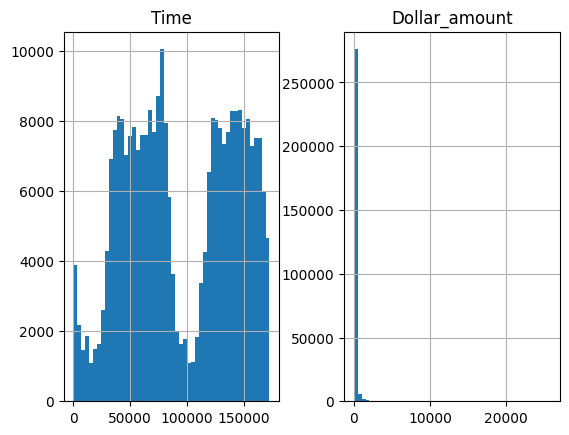

In [11]:
# Check the distribution of the continuous variables Time and Dollar_amount
df.hist(column=['Time', 'Dollar_amount'], bins=50)
plt.show()

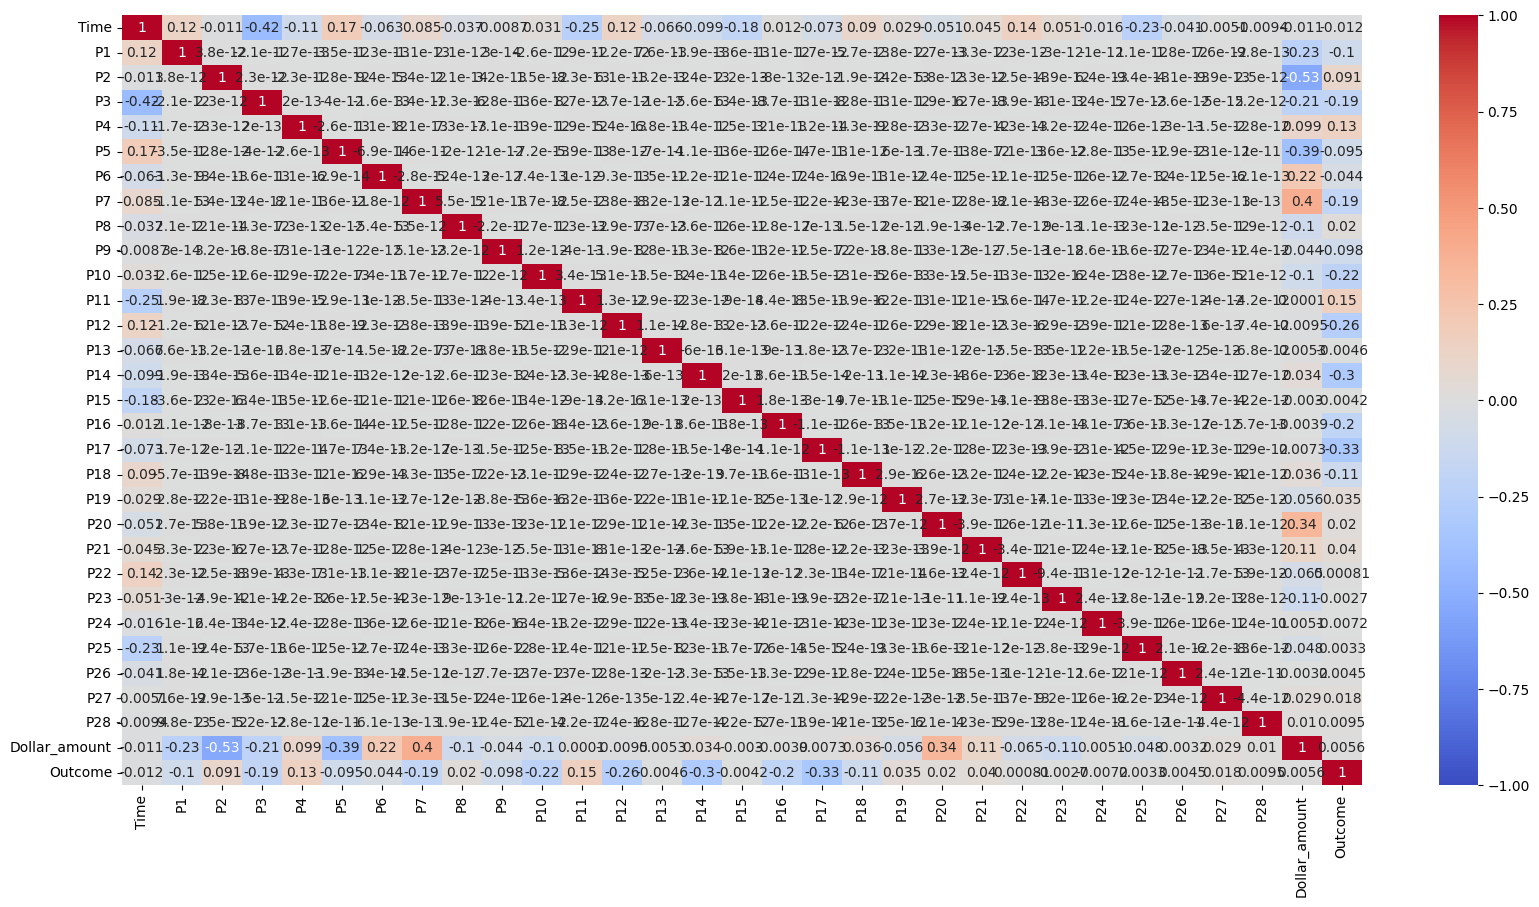

In [12]:
# Let us check the correlation between the variables

plt.figure(figsize=(20,10))

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Data Cleaning

In [13]:
# Remove duplicate records if any

df=remove_duplicate_records(df)

removing 1081 duplicate records


In [14]:
# Check for feature columns that has Missing/NaN values

#print(df.isnull().sum())

nan_columns = df.columns[df.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)


Columns with NaN values: ['Dollar_amount']


In [15]:
# Drop columns with NaN values
# We find Dollar_amount column to have NaN for 12 records. We delete these records from the dataset

print('Data shape before: ',df.shape)
df = df.dropna(subset=['Dollar_amount'])
print('Data shape after: ',df.shape)

Data shape before:  (283726, 31)
Data shape after:  (283714, 31)


In [16]:
# Scaling features to have zero mean and unit variance

df= standardize_features(df, ['Time', 'Dollar_amount'])

In [17]:
smallBeforeScaling=dfo['Dollar_amount'].min()
largeBeforeScaling=dfo['Dollar_amount'].max()

smallAfterScaling=df['Dollar_amount'].min()
largeAfterScaling=df['Dollar_amount'].max()

print('Smallest value Before Scaling = %.2f. | Largest value Before Scaling = %.2f' %(smallBeforeScaling,largeBeforeScaling))
print('Smallest value After Scaling = %.2f. | Largest value After Scaling = %.2f' %(smallAfterScaling,largeAfterScaling))

print('\nBefore scaling: Mean is %.2f | Variance is %.2f' %(dfo['Dollar_amount'].mean(),dfo['Dollar_amount'].var()))
print('After scaling: Mean is %.2f | Variance is %.2f' %(df['Dollar_amount'].mean(),df['Dollar_amount'].var()))



Smallest value Before Scaling = 0.00. | Largest value Before Scaling = 25691.16
Smallest value After Scaling = -0.35. | Largest value After Scaling = 102.25

Before scaling: Mean is 88.35 | Variance is 62562.50
After scaling: Mean is 0.00 | Variance is 1.00


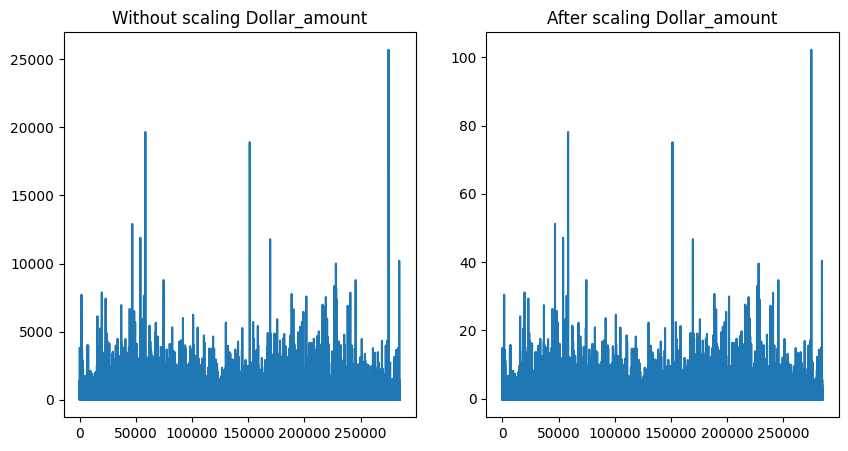

In [18]:
plot_features(dfo,df,'Dollar_amount')

In [19]:
df['Dollar_amount'].max()

102.24556292405137

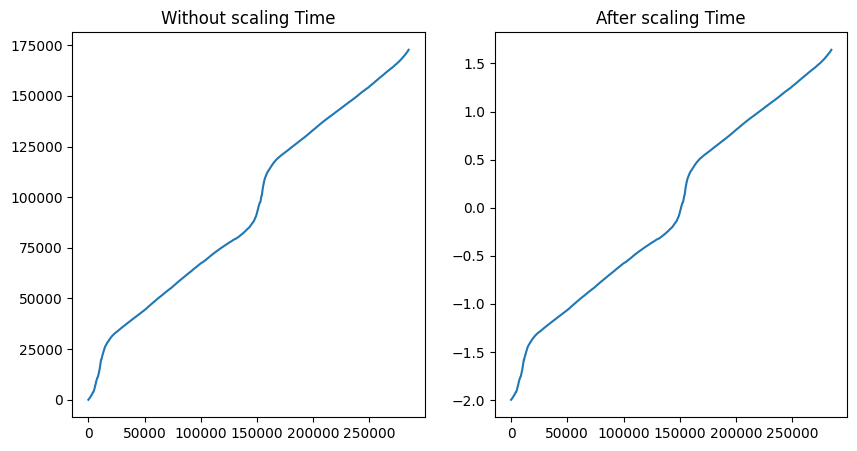

In [20]:
# Plot time feature column
plot_features(dfo,df,'Time')

# Some observations from Initial Data Exploration

From the given dataset only P1--P28 features were PCA transformed (these 28 columns are on similar scale values). But the two features: Time and Dollar_Amount are unscaled features and has high range values that do not match with the other 28 feature values. Thus it is very important to ensure that every features are in similar range scale. We will have to apply normalisation on these two features leaving others as it is.

From the above plots we observe the following:

   * The target variable Outcome is highly imbalanced, with only 0.17% of the transactions being fraudulent. There are only 473 instances of fraud compared to 283,253 non-fraudulent transactions. Therefore, we will have to take this factor into account while building predictive models on this dataset
   * The continuous variables Time and Dollar_amount are highly skewed, with a majority of the transactions having a low dollar amount. 
   * We do not find any strong correlation between the variables in the dataset.
   
   * We find 1081 duplicated records. We remove them from the dataset as they do not offer any contribution.
   
   

# Cost Sensitive learning approaches due to heavy class imbalalnce


The idea behind this cost sensitive learning approach is to put higher penalty for minority class during the learning process so that the model would not be completely biased on majority class while ignoring to detect fraudulent transactions.


In [21]:
# Extract input features (X) and target variable (y)

X = df.drop('Outcome', axis=1)                                        # Only PCA features
y = df['Outcome']                                                     # Target 


non_pca_features = df[['Time','Dollar_amount']]                       # Non PCA features

In [22]:
#print(non_pca_features.head())
#print(X.head)


## Perform 80-20 data split. 80% for training and 20% for evaluation

In [23]:
# Split data into train (80 %) and test set (20 %)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('Total Fraud instances in Training set = %d' %(np.count_nonzero(y_train)))
print('Total Fraud instances in Test set = %d' %(np.count_nonzero(y_test)))
      
X_train.shape

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

Total Fraud instances in Training set = 385
Total Fraud instances in Test set = 88


# Logistic Regression: larger weight for minority class

Training Logistic Regression model ...


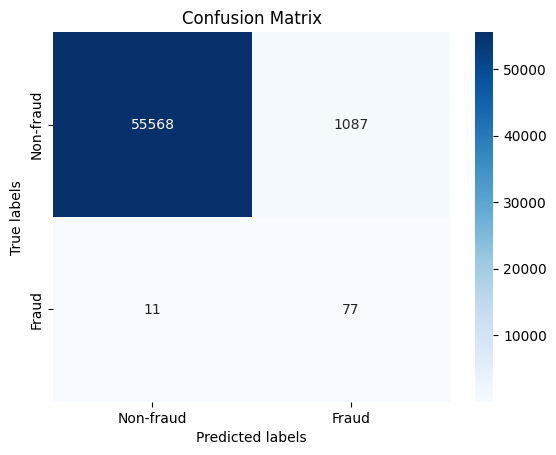



              precision    recall  f1-score   support

   Non-fraud       1.00      0.98      0.99     56655
       Fraud       0.07      0.88      0.12        88

    accuracy                           0.98     56743
   macro avg       0.53      0.93      0.56     56743
weighted avg       1.00      0.98      0.99     56743



In [24]:
# Case 1. Logistic Regression. High class weight for minor class
# Use all 28 PCA components along with standardized Time and Dollar features. 

class_weights = {0: 1, 1: 500}       # we experimented with different values: [10,50,100,200,300,400,500]
classifier='LogisticRegression'      # we find best result in terms of recall for fraud class with weigtht=500

model = train_model(X_train,y_train,classifier,class_weights)
y_pred = test_model(model, X_test)

plot_confusion_matrix(y_test,y_pred)
print('\n')
print_report(y_test,y_pred)

Training Logistic Regression model ...


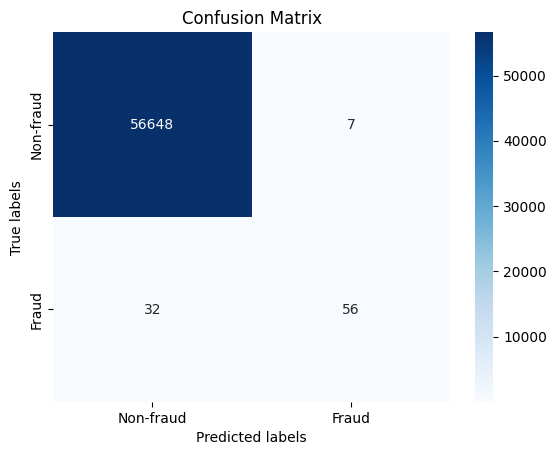



              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     56655
       Fraud       0.89      0.64      0.74        88

    accuracy                           1.00     56743
   macro avg       0.94      0.82      0.87     56743
weighted avg       1.00      1.00      1.00     56743



In [25]:
# Case 2. Logistic Regression. Without any class weights. 
# Use all 28 PCA components along with standardized Time and Dollar features. 

class_weights = None
classifier='LogisticRegression'

model = train_model(X_train,y_train,classifier,class_weights)
y_pred = test_model(model, X_test)

plot_confusion_matrix(y_test,y_pred)
print('\n')
print_report(y_test,y_pred)

# In this setting, more fraud transactions goes undetected.

### Key observation

Weighing minority class improves fraud detection - better Recall

    * Fraud class Recall = 0.88 for weighted model
    * Fraud class Recall = 0.64 without class weighing.
    
    

# DecisionTree classifier: weighing minority class

Training DecisionTreeClassifier ...


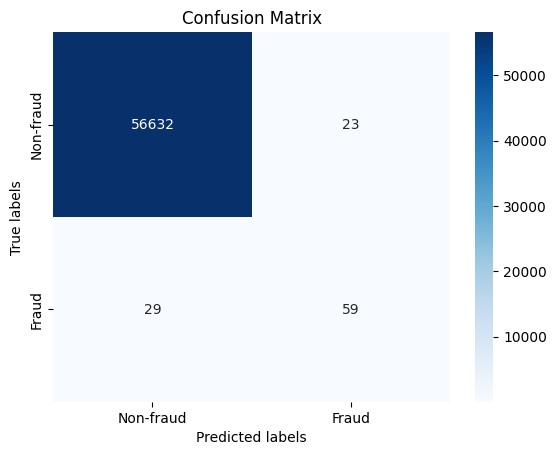



              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     56655
       Fraud       0.72      0.67      0.69        88

    accuracy                           1.00     56743
   macro avg       0.86      0.84      0.85     56743
weighted avg       1.00      1.00      1.00     56743



In [26]:
# Case 3. DecisionTreeClassifier. High class weight for minor class
# Use all 28 PCA components along with standardized Time and Dollar features. 

class_weights = {0: 1, 1: 10}
classifier='DecisionTree'

model = train_model(X_train,y_train,classifier,class_weights)
y_pred = test_model(model, X_test)

plot_confusion_matrix(y_test,y_pred)
print('\n')
print_report(y_test,y_pred)

# DecisionTree classifier: no class weighing

Training DecisionTreeClassifier ...


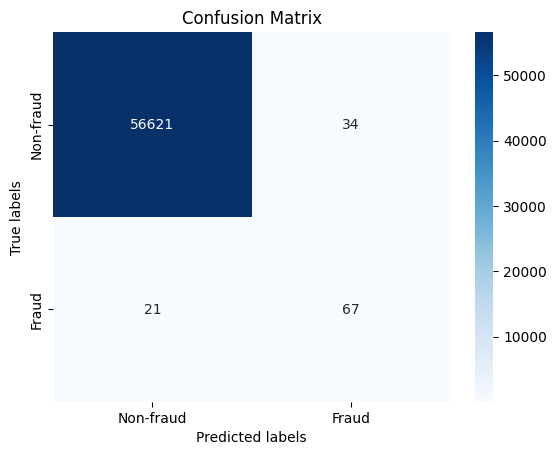



              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     56655
       Fraud       0.66      0.76      0.71        88

    accuracy                           1.00     56743
   macro avg       0.83      0.88      0.85     56743
weighted avg       1.00      1.00      1.00     56743



In [27]:
# Case 4. DecisionTreeClassifier. No weights for minor class
# Use all 28 PCA components along with standardized Time and Dollar features. 

class_weights = None
classifier='DecisionTree'

model = train_model(X_train,y_train,classifier,class_weights)
y_pred = test_model(model, X_test)

plot_confusion_matrix(y_test,y_pred)
print('\n')
print_report(y_test,y_pred)

# Feature Selection

### How many principal components to use?

The features P1-P28 are principal components. So using all might not be helpful and keeping only those components that explains larger variance in original dataset would be much helpful.



In [28]:
# Let us just take top K PCA components and train the model
# Fit the model for various values of K = 5, 10, 15, 20, 25]. Record performance for each of these models
# Include and exclude Time and Amount variables and later see how performance changes

# Case 1. Logistic Regression. High class weight for minor class
# Use all 28 PCA components along with standardized Time and Dollar features. 

class_weights = {0: 1, 1: 500}
classifier='LogisticRegression'
components=[3,6,9,12,15,18,21,24,28]

def find_best_model(X,y,feature_selection_method='first_K_PCA',use_non_pca_features=False):

    fraud_recalls = list()
    fraud_precisions = list()

    nonFraud_recalls=list()
    nonFraud_precisions=list()
    
    selected_columns_list=list()

    for k in components:
        if feature_selection_method == 'first_K_PCA':
            data = get_first_K_components(X, k, use_non_pca_features)
        else:
            print('selecting best %d features..'%(k))
            selected_columns = get_best_k_features(X, y,k)    # calls scikit-learn method
            data = X[selected_columns]
            selected_columns_list.append(selected_columns)
        
        #print(data.shape)
    
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=42)
    
        #print(len(X_train),len(y_train))
        assert(len(X_train)==len(y_train))

        model = train_model(X_train,y_train,classifier,class_weights)  #Train model for the current parameters
        y_pred = test_model(model, X_test)                             #Test the model
    
        cm = metrics.confusion_matrix(y_test, y_pred)
        #print(cm)
    
        #For Fraud class
        precision, recall = compute_precision_recall(cm, positive_class='Fraud')
        #print('Fraud class\t: Precision = %.2f | Recall = %.2f'%(precision,recall))
        fraud_recalls.append(recall)
        fraud_precisions.append(precision)
    
        precision, recall = compute_precision_recall(cm, positive_class='Non-Fraud')
        #print('Non-Fraud class\t: Precision = %.2f | Recall = %.2f'%(precision,recall))
        nonFraud_recalls.append(recall)
        nonFraud_precisions.append(precision)
    
        #plot_confusion_matrix(y_test,y_pred)
        #print('\n')
        #print_report(y_test,y_pred)
        #report = classification_report(y_test, y_pred, target_names=class_names)

        
    return fraud_recalls, nonFraud_recalls, selected_columns_list

def print_recalls(components, recalls):
    # A helper function to print the Recall for Fraud class
    
    print('\nComponent | Fraud Recall ')
    for i in range(len(components)):
        print('%d -> %.2f'%(components[i],recalls[i]))

Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...

Component | Fraud Recall 
3 -> 0.76
6 -> 0.83
9 -> 0.83
12 -> 0.88
15 -> 0.89
18 -> 0.89
21 -> 0.89
24 -> 0.89
28 -> 0.88


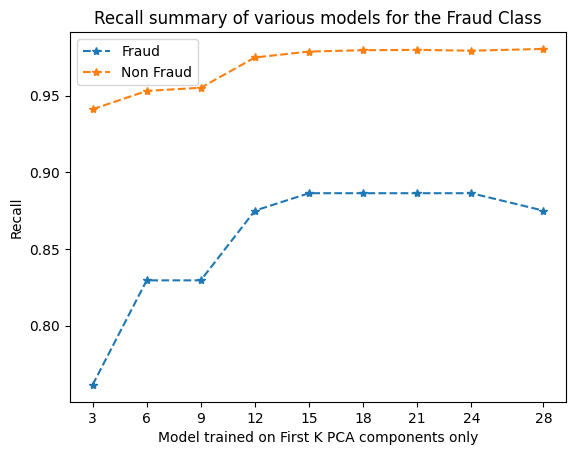

In [29]:
# Setting 1: use first K PCA features 

feature_selection_method = 'first_K_PCA'
fraud_recalls, nonFraud_recalls,_ = find_best_model(X,y,feature_selection_method)

print_recalls(components, fraud_recalls)

x = components
plt.plot(x,fraud_recalls, '*--',label='Fraud')
plt.plot(x,nonFraud_recalls,'*--',label='Non Fraud')

xticks = x
plt.xticks(xticks)
plt.title('Recall summary of various models for the Fraud Class')
plt.xlabel('Model trained on First K PCA components only')
plt.ylabel('Recall')
plt.legend()


Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...
Training Logistic Regression model ...

Component | Fraud Recall 
3 -> 0.82
6 -> 0.84
9 -> 0.86
12 -> 0.88
15 -> 0.89
18 -> 0.89
21 -> 0.89
24 -> 0.89
28 -> 0.88


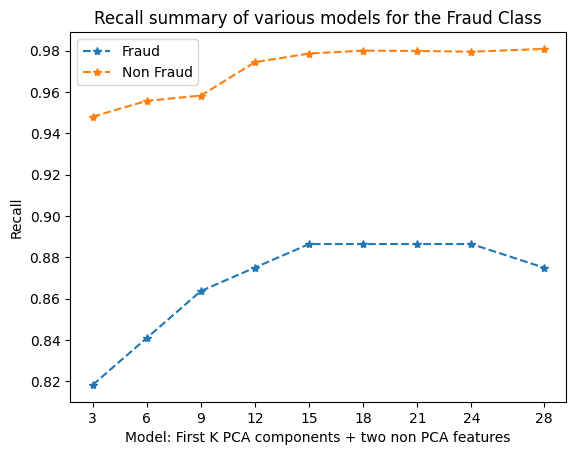

In [30]:
# Setting 2: use first K PCA features + the two non pca features

feature_selection_method = 'first_K_PCA'
use_non_pca_features=True
fraud_recalls, nonFraud_recalls, _ = find_best_model(X,y,feature_selection_method,use_non_pca_features)

print_recalls(components, fraud_recalls)
    
x = components
plt.plot(x,fraud_recalls, '*--',label='Fraud')
plt.plot(x,nonFraud_recalls,'*--',label='Non Fraud')

xticks = x
plt.xticks(xticks)
plt.title('Recall summary of various models for the Fraud Class')
plt.xlabel('Model: First K PCA components + two non PCA features')
plt.ylabel('Recall')
plt.legend()


### Observation

What we understand from above two plots is that using the two Non PCA features: Time and Dollar_amount does not seem to help much in the classification task. We obtain a similar level of performance (as judged by the Recall for Fraud class) by just using 15 first PCA features.

selecting best 3 features..
Training Logistic Regression model ...
selecting best 6 features..
Training Logistic Regression model ...
selecting best 9 features..
Training Logistic Regression model ...
selecting best 12 features..
Training Logistic Regression model ...
selecting best 15 features..
Training Logistic Regression model ...
selecting best 18 features..
Training Logistic Regression model ...
selecting best 21 features..
Training Logistic Regression model ...
selecting best 24 features..
Training Logistic Regression model ...
selecting best 28 features..
Training Logistic Regression model ...

Component | Fraud Recall 
3 -> 0.86
6 -> 0.86
9 -> 0.88
12 -> 0.88
15 -> 0.88
18 -> 0.88
21 -> 0.89
24 -> 0.89
28 -> 0.89


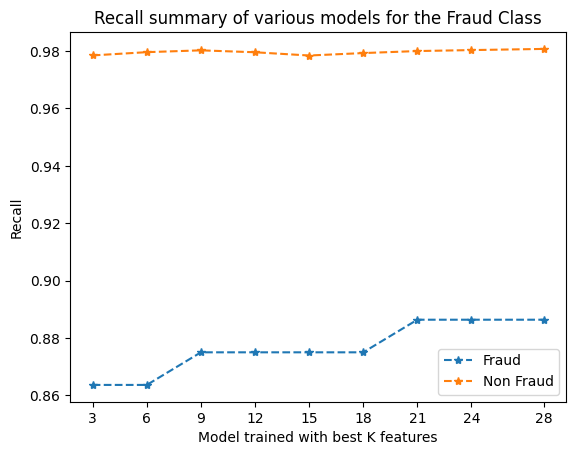

In [31]:
# Logistic Regression using only top K features returned by the algorithm SelectKBest

feature_selection_method = 'SelectKBest'
fraud_recalls, nonFraud_recalls, selected_columns_list = find_best_model(X,y,feature_selection_method)
 
print_recalls(components, fraud_recalls)

x = components
plt.plot(x,fraud_recalls, '*--',label='Fraud')
plt.plot(x,nonFraud_recalls,'*--',label='Non Fraud')

xticks = x
plt.xticks(xticks)
plt.title('Recall summary of various models for the Fraud Class')
plt.xlabel('Model trained with best K features')
plt.ylabel('Recall')
plt.legend()


In [32]:
# From the above results we see model achieves 0.88 recall using 9 top features.
# Lets see what those 9 top feature columns are

print(selected_columns_list[2])

Index(['P3', 'P4', 'P7', 'P10', 'P11', 'P12', 'P14', 'P16', 'P17'], dtype='object')


# Final Takeaway


When it comes to fraud detection, it is important to minimize false negatives, i.e., identifying a transaction as legitimate when it is actually fraudulent. This is because the cost of missing a fraudulent transaction can be high and can result in financial losses for the organization as well as damage to its reputation. Therefore, we need to ensure that our fraud detection model has a high recall for the fraud class, which means it should identify as many fraudulent transactions as possible. Thus we have used Recall as our focus in chosing the model, and we have not focussed on accuracy in judging model performance (and selection).


Following are the findings from this study

    * Best optimal features would be to use the first 15 PCA component features P1 to P15.
    * We get Fraud class Recall of 0.89 by training a LR model on first 15 PCA features.
    * Adding the Time and Dollar_amount did not impact performance. Using them did not help.
    * Furthermore the Scikit-Learn method SelectKBest show comparable performance with the model trained on 15 PCA features.
    
Although we see that SelectKBest method returns a model giving 0.88 Recall with top 9 features. These features do not seem to include P1, P2 as they are the ones with higher variance that explains the underlying data distribution. Thus we tend to go for first 15 PCA feature based LR model that showed 0.89 Fraud Recall on the test data set.